In [1]:
%reload_ext autoreload
%autoreload 2

#%matplotlib notebook
%matplotlib inline

from math import pi
import numpy as np
import matplotlib.pylab as plt

import gtsam

# 1. Pose2SLAM example

Adopted from `python/gtsam/tests/test_Pose2SLAMExample.py`

Optimizing...
initial error = 20.108558223490085
final error = 8.219132306212647e-18


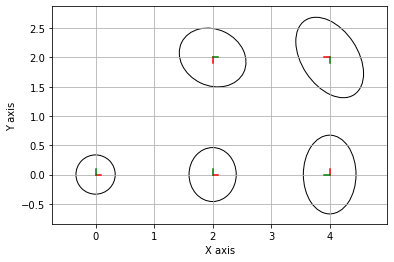

In [2]:
import plot
import audio_stack

graph = gtsam.NonlinearFactorGraph()

# prior
prior_mean = gtsam.Pose2(0.0, 0.0, 0.0)  # prior at origin
prior_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.3, 0.3, 0.1]))
graph.add(gtsam.PriorFactorPose2(1, prior_mean, prior_noise))

# odometry
odometry_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.2, 0.2, 0.1]))
graph.add(
    gtsam.BetweenFactorPose2(1, 2, gtsam.Pose2(2.0, 0.0, 0.0), odometry_noise))
graph.add(
    gtsam.BetweenFactorPose2(2, 3, gtsam.Pose2(2.0, 0.0, pi / 2),
                             odometry_noise))
graph.add(
    gtsam.BetweenFactorPose2(3, 4, gtsam.Pose2(2.0, 0.0, pi / 2),
                             odometry_noise))
graph.add(
    gtsam.BetweenFactorPose2(4, 5, gtsam.Pose2(2.0, 0.0, pi / 2),
                             odometry_noise))

# loop closure
model = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.2, 0.2, 0.1]))
graph.add(gtsam.BetweenFactorPose2(5, 2, gtsam.Pose2(2.0, 0.0, pi / 2), model))

# initialization
initial_estimate = gtsam.Values()
initial_estimate.insert(1, gtsam.Pose2(0.5, 0.0, 0.2))
initial_estimate.insert(2, gtsam.Pose2(2.3, 0.1, -0.2))
initial_estimate.insert(3, gtsam.Pose2(4.1, 0.1, pi / 2))
initial_estimate.insert(4, gtsam.Pose2(4.0, 2.0, pi))
initial_estimate.insert(5, gtsam.Pose2(2.1, 2.1, -pi / 2))

# Optimize using Levenberg-Marquardt optimization with an ordering from colamd
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_estimate)
print("Optimizing...")
result = optimizer.optimizeSafely()
print('initial error = {}'.format(graph.error(initial_estimate)))
print('final error = {}'.format(graph.error(result)))

# plot results
marginals = gtsam.Marginals(graph, result)
plt.figure()
for i in range(1, 6):
    result.atPose2(i)
    #x, y, angle = result.atPose2(i).x(), result.atPose2(i).y(), result.atPose2(
    #    i).theta()
    P = marginals.marginalCovariance(i)
    #plt.scatter(x, y, s=50, label=f'pose {i}')
    #plt.arrow(x, y, np.cos(angle), np.sin(angle), width=0.01)
    plot.plot_pose2(
        1,
        pose=result.atPose2(i),
        covariance=P,
    )
plt.axis('equal')
#plt.legend(loc='upper left')
plt.grid()


# 2. SFM example

Adopted from `http://docs.ros.org/en/melodic/api/gtsam/html/SFMExample_8py_source.html`

Optimizing...
initial error = 1561.9958516005265
final error = 4.465299498725455e-18


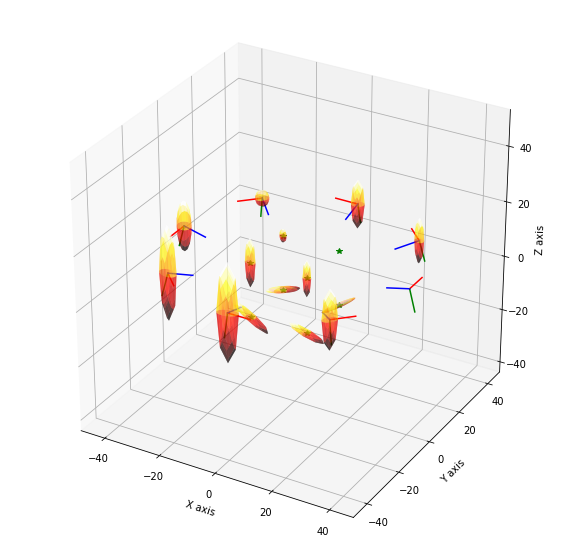

In [3]:
from gtsam import symbol_shorthand
L = symbol_shorthand.L
X = symbol_shorthand.X

from gtsam.examples import SFMdata
from gtsam import (Cal3_S2, DoglegOptimizer,
                         GenericProjectionFactorCal3_S2, Marginals,
                         NonlinearFactorGraph, PinholeCameraCal3_S2, Point3,
                         Pose3, PriorFactorPoint3, PriorFactorPose3, Rot3, Values)

# Define the camera calibration parameters
K = Cal3_S2(50.0, 50.0, 0.0, 50.0, 50.0)

# Define the camera observation noise model
measurement_noise = gtsam.noiseModel.Isotropic.Sigma(2, 1.0)  # one pixel in u and v

# Create the set of ground-truth landmarks
points = SFMdata.createPoints()

# Create the set of ground-truth poses
poses = SFMdata.createPoses(K)

# Create a factor graph
graph = NonlinearFactorGraph()

# Add a prior on pose x1. This indirectly specifies where the origin is.
# 0.3 rad std on roll,pitch,yaw and 0.1m on x,y,z
pose_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.3, 0.3, 0.3, 0.1, 0.1, 0.1]))
factor = PriorFactorPose3(X(0), poses[0], pose_noise)
graph.push_back(factor)

# Simulated measurements from each camera pose, adding them to the factor graph
for i, pose in enumerate(poses):
    camera = PinholeCameraCal3_S2(pose, K)
    for j, point in enumerate(points):
        measurement = camera.project(point)
        factor = GenericProjectionFactorCal3_S2(
            measurement, measurement_noise, X(i), L(j), K)
        graph.push_back(factor)

# Because the structure-from-motion problem has a scale ambiguity, the problem is still under-constrained
# Here we add a prior on the position of the first landmark. This fixes the scale by indicating the distance
# between the first camera and the first landmark. All other landmark positions are interpreted using this scale.
point_noise = gtsam.noiseModel.Isotropic.Sigma(3, 0.1)
factor = PriorFactorPoint3(L(0), points[0], point_noise)
graph.push_back(factor)
#graph.print('Factor Graph:\n')

# Create the data structure to hold the initial estimate to the solution
# Intentionally initialize the variables off from the ground truth
initial_estimate = Values()
for i, pose in enumerate(poses):
    transformed_pose = pose.retract(0.1*np.random.randn(6,1))
    initial_estimate.insert(X(i), transformed_pose)
for j, point in enumerate(points):
    transformed_point = point + 0.1*np.random.randn(3)
    initial_estimate.insert(L(j), transformed_point)
#initial_estimate.print('Initial Estimates:\n')

# Optimize the graph and print results
params = gtsam.DoglegParams()
#params.setVerbosity('TERMINATION')
params.setVerbosity('')
optimizer = DoglegOptimizer(graph, initial_estimate, params)
print('Optimizing...')
result = optimizer.optimize()
#result.print('Final results:\n')
print('initial error = {}'.format(graph.error(initial_estimate)))
print('final error = {}'.format(graph.error(result)))

#print(result)

marginals = Marginals(graph, result)
fig = plt.figure()
plot.plot_3d_points(1, result, marginals=marginals, cov_scale=0.1)
plot.plot_trajectory(1, result, cov_scale=0.1, marginals=marginals, axis_length=8)
plot.set_axes_equal(1)
fig.set_size_inches(10, 10)

# 3. Planar SLAM example

In [4]:
def get_angles(unit_vector, verbose=False):
    azimuth = np.arctan2(unit_vector[1], unit_vector[0]) * 180 / np.pi
    elevation = np.arcsin(unit_vector[2]) * 180 / np.pi
    if verbose:
        print(f"angles: azimuth={azimuth:.0f}deg, elevation={elevation:.0f}deg")
    return azimuth, elevation

def get_vector(azimuth, elevation):
    return np.r_[
        np.cos(azimuth) * np.cos(elevation), 
        np.sin(azimuth) * np.cos(elevation),
        np.sin(elevation)
    ]

def print_plane(label, plane):
    print(f"{label} distance: {plane.distance():.2f}", end="\t")
    normal = plane.normal().point3()
    #print(f"{label} normal:", normal)
    get_angles(normal, verbose=True)

def plot_all(estimate, axis_length=0.2, top=True, side=True):
    fig = plt.figure(0)
    fig.set_size_inches(10, 10)
    plot.plot_trajectory(0, estimate, axis_length=axis_length)
    plot.set_axes_equal(0)

    if side:
        fig = plt.figure(1)
        fig.set_size_inches(10, 10)
        plot.plot_trajectory(1, estimate, axis_length=axis_length)
        plot.set_axes_equal(1)
        plt.gca().view_init(elev=0., azim=0)
        plt.title("side view")

    if top:
        fig = plt.figure(2)
        fig.set_size_inches(10, 10)
        plot.plot_trajectory(2, estimate, axis_length=axis_length)
        plot.set_axes_equal(2)
        plt.gca().view_init(elev=90., azim=0)
        plt.title("top view")

# TODO: need functions to
# - calculate bearing to a plane
# - calculate range to a plane
# just like Pose3.bearing(Pose3) or Pose3.range(pose3)

## 3.1 Understand the plane object

initial distance: 1.00	angles: azimuth=-90deg, elevation=-0deg
second distance: 0.80	angles: azimuth=-135deg, elevation=-0deg
second distance: 0.66	angles: azimuth=-180deg, elevation=-0deg
second distance: 0.66	angles: azimuth=135deg, elevation=-0deg
second distance: 0.80	angles: azimuth=90deg, elevation=-0deg
second distance: 1.00	angles: azimuth=45deg, elevation=-0deg
second distance: 1.14	angles: azimuth=0deg, elevation=-0deg
second distance: 1.14	angles: azimuth=-45deg, elevation=-0deg
second distance: 1.00	angles: azimuth=-90deg, elevation=-0deg


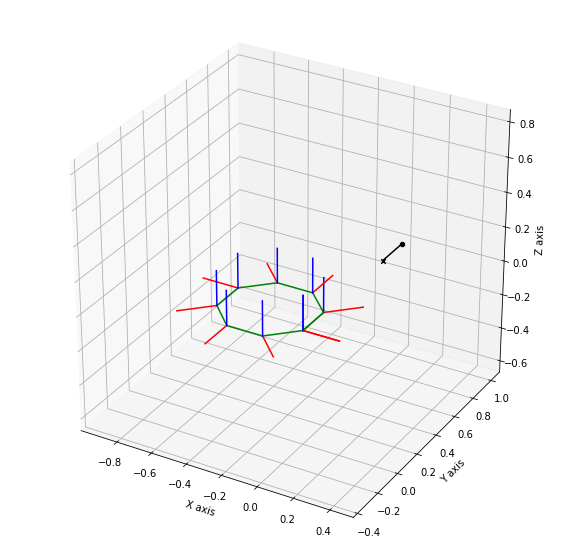

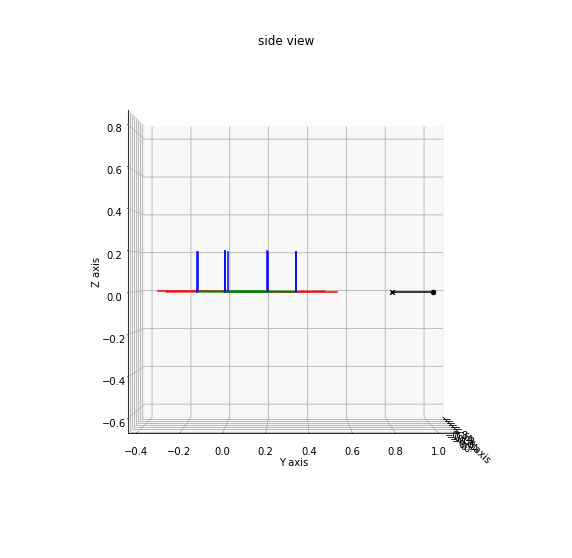

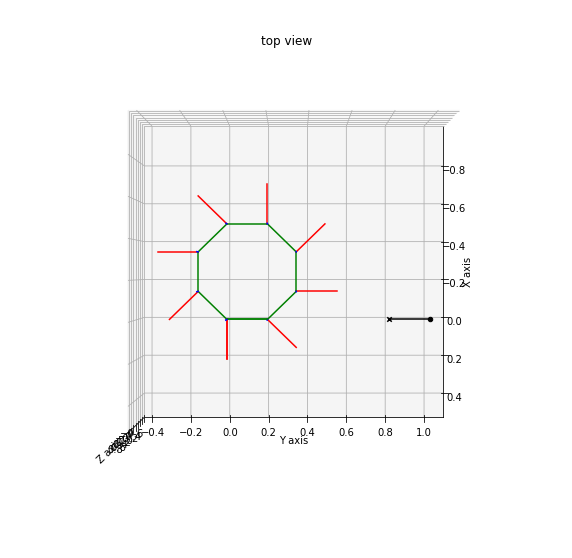

In [5]:
from gtsam import Unit3, Pose2
from gtsam import OrientedPlane3 as Plane

X = symbol_shorthand.X
P = symbol_shorthand.P

estimate = Values()
plane = Plane(n=Unit3(-np.array([0.0, 1.0, 0])), d=1.0) # in local coordinates
estimate.insert(P(0), plane)

# first pose at origin
pose0 = Pose3(r=Rot3.Ypr(0.0, 0.0, 0.0), t=Point3(0.0, 0.0, 0.0))
estimate.insert(X(0), pose0)
print_plane("initial", plane)

pose1 = pose0
for i in np.arange(8):
    # first t, then r!
    pose_delta = Pose3(r=Rot3.Ypr(np.pi/4, 0, 0), t=Point3(0.0, 0.2, 0.0))#, t=Point3(0.0, 0.1, 0.0))
    pose1 = pose1 * pose_delta
    estimate.insert(X(i+1), pose1)
    plane2 = plane.transform(pose1) #, plane)
    print_plane("second", plane2)

plot_all(estimate)

## 3.2 Simulate measurements

In [6]:
def rad(deg):
    return deg / 180 * np.pi
def deg(rad):
    return rad * 180 / np.pi

class WallSimulation(object):
    """
    Wall simulation: 
    - we have a fixed velocity (linear and angular)
    - we start from a given pose and plane
    - 
    """
    def __init__(self):
        self.v = np.array([0, 0.1, 0]); 
        self.noise_v = gtsam.noiseModel.Isotropic.Sigma(3, 0.01) # m/s, linear velocity
        self.w = np.array([0.1, 0, 0]); 
        self.noise_w = gtsam.noiseModel.Isotropic.Sigma(3, rad(1)) # rad/s (yaw, pitch, roll)
        self.time = 0
        
        # xyz
        self.noise_p = gtsam.noiseModel.Diagonal.Sigmas([0.02, 0.02, 0.001])
        # ypr
        self.noise_r = gtsam.noiseModel.Diagonal.Sigmas([rad(10), rad(1), rad(1)]) 
        # distance, azimuth, elevation
        self.noise_plane = gtsam.noiseModel.Diagonal.Sigmas([0.1, rad(10), rad(1)])
        self.seed = 0
        
    def initialize(self, plane, pose_0):
        self.plane = plane
        self.pose_0 = pose_0
        self.pose_t = self.pose_0
        
    def move_until_time(self, time=0):
        """ move with noisy velocities until given time 
        """
        delta_t = time - self.time
        v_noisy = delta_t * (self.v + gtsam.Sampler(self.noise_v, self.seed).sample())
        w_noisy = delta_t * (self.w + gtsam.Sampler(self.noise_w, self.seed).sample())
        pose_delta = Pose3(r=Rot3.Ypr(*w_noisy), t=Point3(*v_noisy))
        self.seed += 1
        self.pose_t = pose_delta * self.pose_t
        self.time = time
        
    def real_pose(self):
        return self.pose_t
    
    def expected_pose(self, time=None):
        """ currently expected pose, given the velocities """
        if time is None:
            time = self.time
        pose_delta = Pose3(r=Rot3.Ypr(*(self.w * time)), t=Point3(*(self.v * time)))
        return pose_delta * self.pose_0
    
    def measure_pose(self):
        pose_delta = Pose3(t=gtsam.Sampler(self.noise_p, self.seed).sample(),
                           r=Rot3.Ypr(*gtsam.Sampler(self.noise_r, self.seed).sample()))
        return pose_delta * self.pose_t
    
    def measure_plane(self):
        plane_gt = self.plane.transform(self.pose_t)
        azimuth_deg, elevation_deg = get_angles(plane_gt.normal().point3())
        distance = plane_gt.distance()
        azimuth = rad(azimuth_deg)
        elevation = rad(elevation_deg)
        
        noise = gtsam.Sampler(self.noise_plane, self.seed).sample()
        distance += noise[0]
        azimuth += noise[1]
        elevation += noise[2]
        
        plane_measured = Plane() 
        normal_vec = get_vector(azimuth, elevation) 
        plane_meas = Plane(n=Unit3(-normal_vec), d=distance)
        return plane_meas, azimuth, elevation, distance

In [7]:
from gtsam import noiseModel, Sampler
wall_simulation = WallSimulation()

initial distance: 1.00	angles: azimuth=-90deg, elevation=0deg
 pose 0 distance: 0.96	angles: azimuth=97deg, elevation=1deg
 pose 1 distance: 0.83	angles: azimuth=82deg, elevation=1deg
 pose 2 distance: 0.66	angles: azimuth=62deg, elevation=3deg
 pose 3 distance: 0.69	angles: azimuth=69deg, elevation=3deg


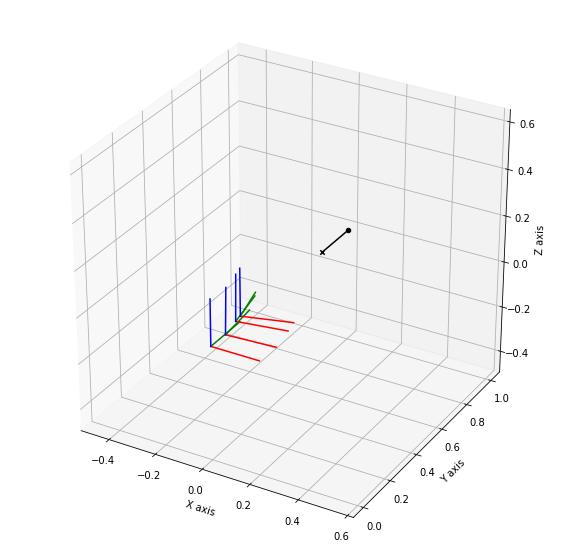

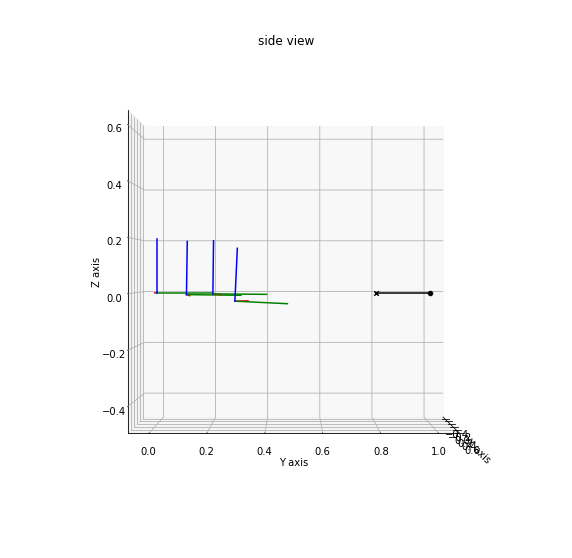

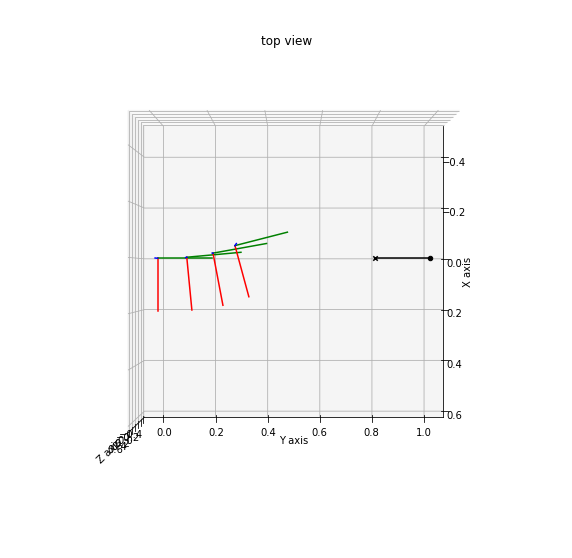

In [8]:
np.random.seed(1)

X = symbol_shorthand.X
P = symbol_shorthand.P

pose_0 = Pose3()
plane = Plane(n=Unit3([0, -1, 0]), d=1.0)
print_plane("initial", plane)

wall_simulation = WallSimulation()
wall_simulation.initialize(plane, pose_0)

estimate = Values()
estimate.insert(P(0), plane)

real = Values()
real.insert(P(0), plane)

for t in range(4):
    wall_simulation.move_until_time(time=t)
    pose_t = wall_simulation.real_pose()
    pose_t_noiseless = wall_simulation.expected_pose(time=t)
    estimate.insert(X(t), pose_t)
    
    # get plane measurements
    plane_local, distance, azimuth, elevation = wall_simulation.measure_plane()
    print_plane(f" pose {t}", plane_local)
plot_all(estimate)
plt.show()

## 3.3 Create factor graph

In [9]:
from gtsam import PriorFactorOrientedPlane3 # is created automatically!
from gtsam import OrientedPlane3Factor as PlaneFactor

times = range(4)
wall_simulation = WallSimulation()
wall_simulation.initialize(plane, pose_0)

# Create and solve factor graph for above example
initial_estimate = Values()
initial_estimate.insert(P(0), plane)

graph = NonlinearFactorGraph()

plane_noise = gtsam.noiseModel.Diagonal.Sigmas([0.8, 0.8, 5])
pose_noise = gtsam.noiseModel.Isotropic.Sigma(6, 0.01)

factor = PriorFactorOrientedPlane3(P(0), plane, plane_noise)
print(f"Added plane factor from pose {0} with distance: {plane.distance():.2f}")
graph.push_back(factor)

#for i, meas in enumerate(measurements.values()):
for time in times: 
    
    wall_simulation.move_until_time(time)
    
    # initialization
    pose_prior = wall_simulation.expected_pose(time)
    initial_estimate.insert(X(time), pose_prior)
    
    # pose estimates
    pose_t = wall_simulation.measure_pose()
    factor = PriorFactorPose3(X(time), pose_t, pose_noise)
    print(f"Added prior factor to pose {time}: {pose_t.translation().round(3)}")
    graph.push_back(factor)
    
    # plane measurements
    plane_meas, azimuth, elevation, distance = wall_simulation.measure_plane()
    factor = PlaneFactor(plane_meas.planeCoefficients(), plane_noise, X(time), P(0))
    graph.push_back(factor)
    print(f"Added plane factor from pose {time} with distance: {plane_meas.distance():.2f}")
    
    # imu measurements

Added plane factor from pose 0 with distance: 1.00
Added prior factor to pose 0: [-0.008  0.014 -0.001]
Added plane factor from pose 0 with distance: 0.96
Added prior factor to pose 1: [-0.005  0.101 -0.007]
Added plane factor from pose 1 with distance: 0.83
Added prior factor to pose 2: [ 0.002  0.167 -0.015]
Added plane factor from pose 2 with distance: 0.66
Added prior factor to pose 3: [-0.041  0.272 -0.038]
Added plane factor from pose 3 with distance: 0.69


## 3.5 Solve factor graph

Optimizing...
initial error = 510.500655255013
final error = 0.16380363561702413


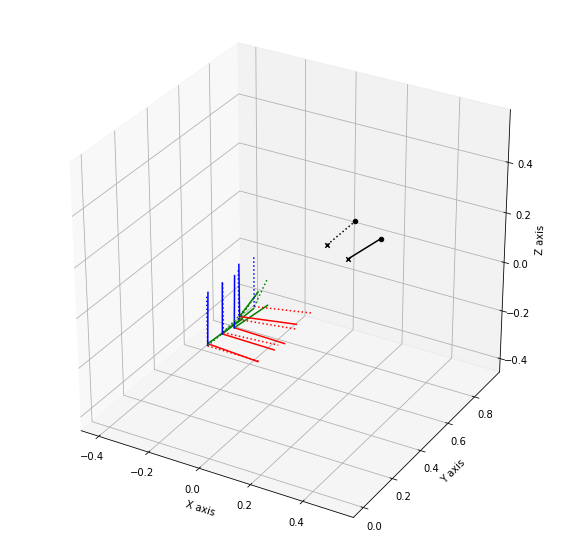

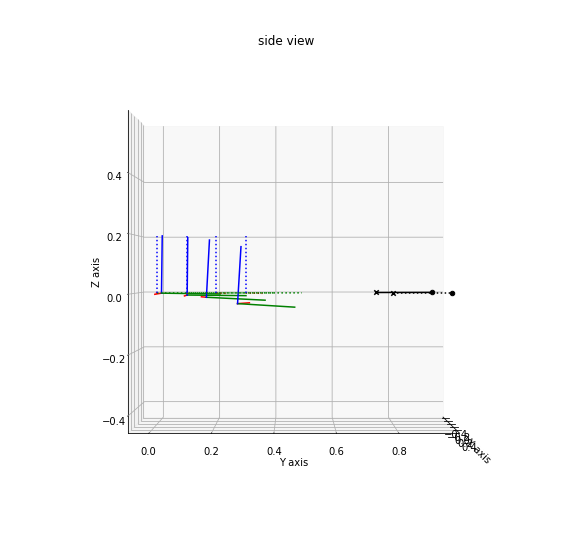

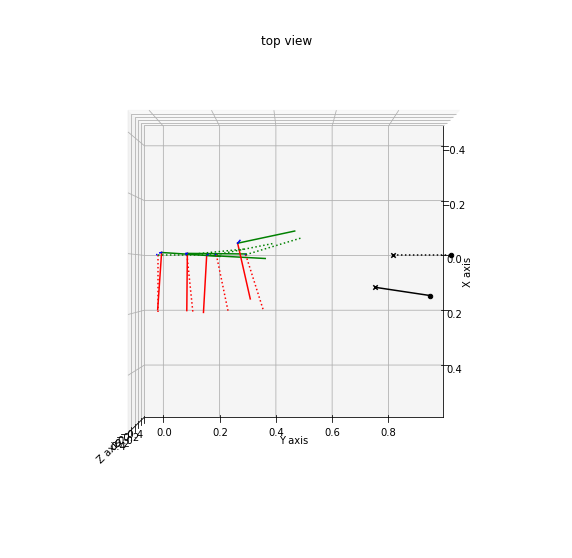

In [10]:
from gtsam import GaussNewtonOptimizer, NonlinearOptimizerParams
#params = gtsam.DoglegParams()
#params = gtsam.GaussNewtonOptimizerParams()
#params.setVerbosity("VALUES")
#print('====================')
#print('Initial estimtae:')
#print(initial_estimate)
#print(params)
#optimizer = DoglegOptimizer(graph, initial_estimate, params)
optimizer = GaussNewtonOptimizer(graph, initial_estimate)
print('Optimizing...')
result = optimizer.optimize()
print('initial error = {}'.format(graph.error(initial_estimate)))
print('final error = {}'.format(graph.error(result)))

plot_all(result)
plot.plot_trajectory(0, initial_estimate, axis_length=0.2, ls=":")
plot.plot_trajectory(1, initial_estimate, axis_length=0.2, ls=":")
plot.plot_trajectory(2, initial_estimate, axis_length=0.2, ls=":")
#marginals = Marginals(graph, result)
#fig = plt.figure()
#plot.plot_trajectory(1, result, cov_scale=0.1, axis_length=0.1)
#plot.set_axes_equal(1)
#fig.set_size_inches(10, 10)

## 3.6 Online inference

### Debugging version

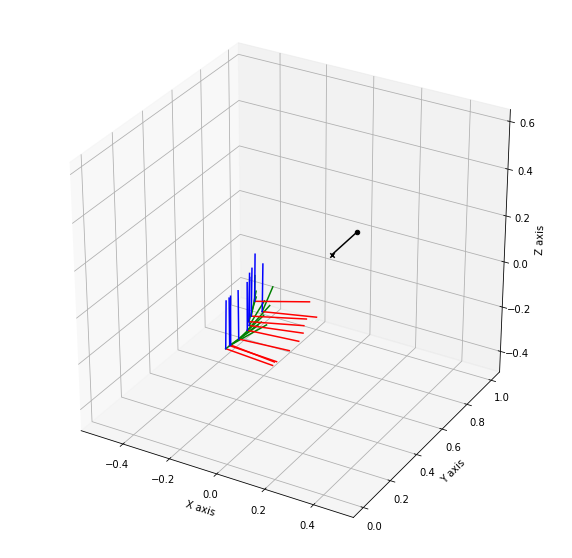

In [25]:
# below is inspired from gtsam/python/tests/test_VisualISAMExample 
# and python/gtsam/utils/visual_isam.py

params = gtsam.ISAM2Params()
params.setRelinearizeSkip(1) # always relinearize

isam = gtsam.ISAM2(params=params)

new_factors = gtsam.NonlinearFactorGraph()
initial_estimates = gtsam.Values()

plane = gtsam.OrientedPlane3(Unit3([0, -1.0, 0]), 1)
pose_0 = gtsam.Pose3()
initial_estimates.insert(P(0), plane)

plane_noise = gtsam.noiseModel.Diagonal.Sigmas([0.8, 0.8, 5])
pose_noise = gtsam.noiseModel.Isotropic.Sigma(6, 0.01)

isam.update(new_factors, initial_estimates)

wall_simulation = WallSimulation()
wall_simulation.initialize(plane, pose_0)

times = np.linspace(0, 4, 10)

for t, time in enumerate(times):
    wall_simulation.move_until_time(time)
    
    pose_prior = wall_simulation.expected_pose()
    pose_t = wall_simulation.measure_pose()
    plane_t = wall_simulation.measure_plane()
    
    factors = gtsam.NonlinearFactorGraph()
    initial_estimates = gtsam.Values()
    
    factor = PriorFactorPose3(X(t), pose_t, pose_noise)
    factors.push_back(factor)
    
    initial_estimates.insert(X(t), pose_prior)
    
    #isam.update(factors, initial_estimates)
    #factors = gtsam.NonlinearFactorGraph()
    #initial_estimates = gtsam.Values()
    
    plane_meas, azimuth, elevation, distance = wall_simulation.measure_plane()
    #print(f"plane factor with {distance, azimuth_deg, elevation_deg}")
    factor = PlaneFactor(plane_meas.planeCoefficients(), plane_noise, X(t), P(0))
    factors.push_back(factor)
    
    isam.update(factors, initial_estimates)
    
    new_result = isam.calculateEstimate()
    
plot_all(new_result, top=False, side=False)
plt.show()

### Live version

adding plane measurement: 0.96 -83.0
adding plane measurement: 0.89 -95.0
adding plane measurement: 0.77 -112.0
adding plane measurement: 0.85 -103.0
adding plane measurement: 0.81 -92.0
adding plane measurement: 0.82 -96.0
adding plane measurement: 0.83 -99.0
adding plane measurement: 0.78 -102.0
adding plane measurement: 0.64 -109.0
adding plane measurement: 0.69 -106.0


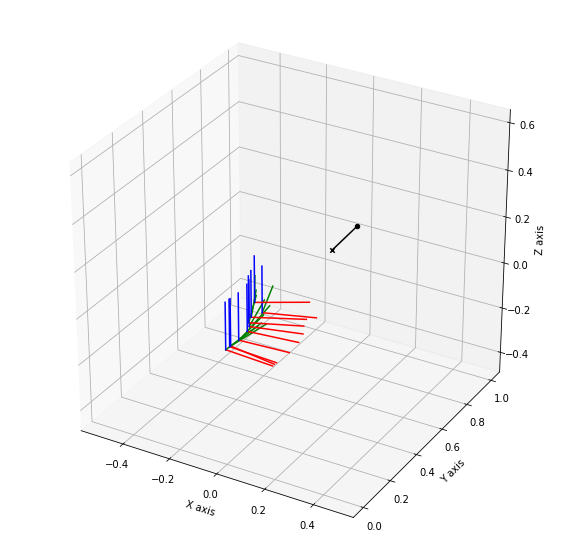

In [27]:
import sys
sys.path.append('../../src/audio_gtsam/')
from audio_gtsam.wall_backend import WallBackend

wall_backend = WallBackend()

plane = gtsam.OrientedPlane3(Unit3([0, -1.0, 0]), 1)
pose_0 = gtsam.Pose3()
wall_simulation = WallSimulation()
wall_simulation.initialize(plane, pose_0)

for t, time in enumerate(times):
    wall_simulation.move_until_time(time)
    
    pose_t = wall_simulation.measure_pose()
    #pose_t = wall_simulation.expected_pose()
    
    plane_meas, azimuth, elevation, distance = wall_simulation.measure_plane()
    
    #print(f"prior factor with {pose_t.translation()}")
    wall_backend.add_pose(r_world=pose_t.translation(), 
                          yaw=pose_t.rotation().yaw())
    print(f"adding plane measurement: {distance:.2f}", round(azimuth * 180 / np.pi))
    wall_backend.add_plane(distance, azimuth, elevation)
    
    planes, poses = wall_backend.get_results()
    #plot_all(new_result, top=False, side=False)
    #plt.show()
plot_all(wall_backend.result, top=False, side=False)
plt.show()